## Model 1 - Basic CNN

In [1]:
# import all the tools we need
import urllib
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import draw_bounding_boxes

import os 
from PIL import Image
import random
import xml.etree.ElementTree as ET
import time
import requests

In [ ]:
dir_path = 'images'
xml_path = 'annotations'

img_list = os.listdir(dir_path)
xml_list = os.listdir(xml_path)
print(len(img_list))

853


In [304]:
def read_img(img_name, dir_path):
    transform = torchvision.transforms.Compose([
        transforms.PILToTensor()
    ])
    image = Image.open(os.path.join(dir_path, img_name)).convert('RGB')

    image_tensor = transform(image).float()
    return(image_tensor)

img = read_img(img_list[0], dir_path)
img.dtype

torch.float32

In [536]:
def read_annot(xml_name, xml_dir):

    bbox = []
    labels = []

    annot_path = os.path.join(xml_dir, xml_name)
    tree = ET.parse(annot_path)
    root = tree.getroot()
    for boxes in root.iter('object'):
        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)
        bbox.append([xmin,ymin,xmax,ymax])

        label = boxes.find('name').text
        if label =='with_mask':
            labels.append(2)
        else:
            labels.append(1)
    
    return torch.tensor(bbox), torch.tensor(labels).float()

bbox, labels = read_annot(xml_list[0], xml_path)
print(bbox.shape, labels.dtype)

torch.Size([3, 4]) torch.float32


In [537]:
class ImageDataset(Dataset):
    def __init__(self, image_list, dir_path, xml_list, xml_path):
        self.image_dir = dir_path
        self.image_list = image_list
        self.xml_dir = xml_path
        self.xml_list = xml_list   
        
    def __len__(self):
        return len(self.image_list)
       
    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        img = read_img(img_name,self.image_dir)
        xml_name = self.xml_list[idx]
        boxes,labels = read_annot(xml_name, xml_path)
               
        return img, boxes, labels

In [538]:
train_set = ImageDataset(img_list, dir_path, xml_list, xml_path)
train_loader = DataLoader(train_set, 
                          batch_size = 1,
                          shuffle = False)

img, box, label = next(iter(train_loader))
print(img.shape, box.shape, label.shape)

torch.Size([1, 3, 366, 512]) torch.Size([1, 3, 4]) torch.Size([1, 3])


In [539]:
# Iterate over each location (i, j)
def box_list(boxes):
    bbox_list = []
    for i in range(boxes.size(2)):
        for j in range(boxes.size(3)):
        # Extract xmin, ymin, xmax, ymax from tensor2
            xmin = boxes[0, 0, i, j]
            ymin = boxes[0, 1, i, j]
            xmax = boxes[0, 2, i, j]
            ymax = boxes[0, 3, i, j]
        
            # Append bounding box coordinates to the list
            bbox_list.append([xmin.item(), ymin.item(), xmax.item(), ymax.item()])
    return torch.tensor(bbox_list)


In [540]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
import torch.nn as nn
from torchvision.models import vgg16, VGG16_Weights
from torchvision.ops import nms

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        vgg = vgg16(weights = VGG16_Weights.DEFAULT)
        self.backbone = vgg.features
        self.classifier = nn.Sequential(
            nn.Conv2d(512, 128, kernel_size = (3,3),stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(128,32, kernel_size = (1,1), stride =(1,1)),
            nn.Conv2d(32, 8, kernel_size = (1,1), stride =(1,1)),
            nn.Conv2d(8,3, kernel_size = (1,1), stride = (1,1)),
            nn.Softmax(dim =1)        
        )
        self.box_regressor = nn.Sequential(
            nn.Conv2d(512,32, kernel_size = (3,3),stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(32,4, kernel_size = (1,1), stride = (1,1))
        )

    def forward(self,x):
        x = self.backbone(x)
        classes = self.classifier(x)
        classes = torch.argmax(classes, dim=1).flatten().float()
        boxes = self.box_regressor(x)
        boxes = box_list(boxes)
        # scores = self.confidence(x)
        # scores = scores.flatten()
        # indices = nms(
        #     boxes = boxes,
        #     scores = scores,
        #     iou_threshold = 0.5,
        #     )
        return classes, boxes
    
net = CNN()
labels, boxes = net(img)
print(labels.shape, boxes.shape)

torch.Size([176]) torch.Size([176, 4])


In [541]:
import torch
from torchvision.ops import box_iou

def find_matches(boxes, box):
    box = box.squeeze(0) 
    best_matches = []
    for i in range(box.shape[0]):
        
        ious = [box_iou(box[i].unsqueeze(0), boxes[j].unsqueeze(0)) for j in range(boxes.shape[0])]
        best_matches.append(np.argmax(ious))
    return best_matches

# Assuming boxes.shape is (176, 4)
# Assuming box.shape is (1, 3, 4)
ious = find_matches(boxes, box)

In [544]:
class CNNLoss(nn.Module):
    def __init__(self):
        super(CNNLoss, self).__init__()
        self.box_loss = nn.MSELoss()
        self.cls_loss = nn.CrossEntropyLoss()

    def forward(self,boxes, box, labels, label): 
        best_matches = find_matches(boxes, box)
        filtered_box = boxes[best_matches].unsqueeze(0) 
        filtered_cls = labels[best_matches].unsqueeze(0)

        mse = self.box_loss(filtered_box, box)
        cross = self.cls_loss(filtered_cls, label)
        total_loss= cross+mse
        return total_loss

loss = CNNLoss()
loss(boxes,box, labels, label)

tensor(35560.8281)

In [546]:
# Initialize optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# Training loop
for epoch in range(1):
    # Iterate over batches
    for img, boxes, labels in train_loader:     
        # Zero gradients
        optimizer.zero_grad()
        labels_pred, boxes_pred = net(img)
        total_loss= loss(boxes_pred,boxes, labels_pred, labels)    
        # Update weights
        optimizer.step()
        
    
    # Print loss
    print(total_loss.item())


40910.91015625


## Model 2- Pretrained model    

In [13]:

def read_img(img_name, dir_path):
    # transform = torchvision.transforms.Compose([
    #     transforms.PILToTensor()
    # ])
    # img  = Image.open(os.path.join(dir_path, img_name)).convert('RGB')
    img = plt.imread(os.path.join(dir_path, img_name))
    return(img)

def read_annot(xml_name, xml_dir):
    bbox = []
    labels = [] 
    annot_path = os.path.join(xml_dir, xml_name)
    tree = ET.parse(annot_path)
    root = tree.getroot()
    for boxes in root.iter('object'):
        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)
        label = boxes.find('name').text
        bbox.append([xmin,ymin,xmax,ymax])
        if label == 'with_mask':
            label_idx = 2
        else:
            label_idx = 1
        labels.append(label_idx)
    return bbox, labels

def draw_boxes(img, boxes,labels, thickness=1):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    for box,label in zip(boxes,labels):
        box = [int(x) for x in box]
        if label == 2:
            color = (0,225,0) # green
        elif label == 1:
            color = (0,0,225) # red
        cv2.rectangle(img, (box[0],box[1]),(box[2],box[3]),color,thickness)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


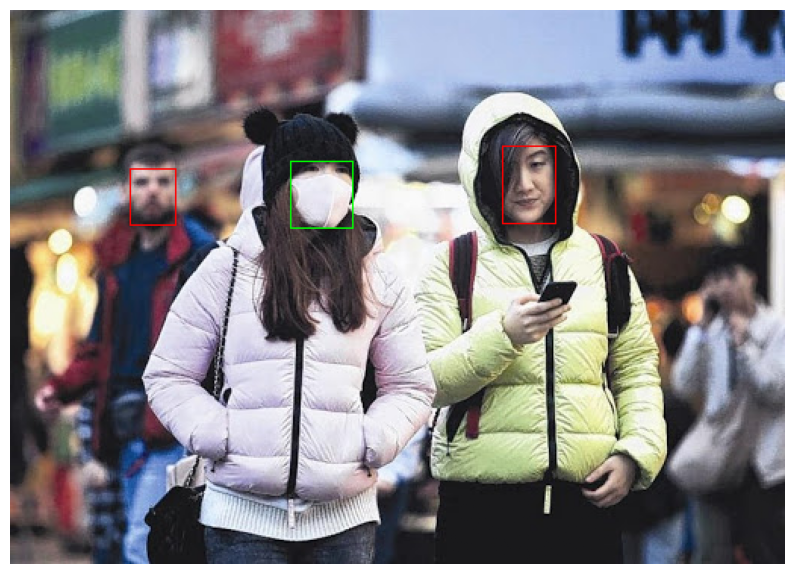

In [21]:
img_dir = 'images'
img_list = os.listdir(img_dir)
xml_dir = 'annotations'
xml_list = os.listdir(xml_dir)

img = read_img(img_list[0], img_dir) # random select an image
bbox, labels  = read_annot(xml_list[0], xml_dir)
img_box = draw_boxes(img, bbox,labels)
    
# display the image
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.axis('off')
ax.imshow(img_box)

class image_dataset(Dataset):
    def __init__(self, image_list, image_dir, xml_list, xml_dir):
        self.image_list = image_list
        self.image_dir = image_dir
        self.xml_list = xml_list
        self.xml_dir = xml_dir
    def __len__(self):
        return len(self.image_list)
    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        img = read_img(img_name, self.image_dir)
        img = transforms.ToTensor()(img)
        xml_name = xml_list[idx]
        bbox, labels = read_annot(xml_name, self.xml_dir)
        boxes = torch.tensor(bbox, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        area = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])
        area = torch.tensor(area, dtype=torch.float32)
        iscrowd = torch.zeros((len(bbox),), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = area
        target['iscrowed'] = iscrowd
        return img, target    
